In [174]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import random
import math
import time 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import norm
import ray
ray.init(num_cpus= 10, ignore_reinit_error=True)
from numba import jit

2023-02-28 12:09:45,322	INFO worker.py:1370 -- Calling ray.init() again after it has already been called.


In [432]:
from sklearn.linear_model import LinearRegression
from linearmodels.iv import IV2SLS
import statsmodels.api as sm
import linearmodels
from statsmodels.iolib.summary2 import summary_col
from scipy.optimize import minimize


In [4]:
# Define True Parameters
alpha_0 = 3
alpha_1 = 1.5
beta_bar = -1
sigma_beta = 0.2
omega_0 = 5
omega_1 = 1
omega_2 = 2
sigma_xi = 1
sigma_xieta = 0.5
sigma_eta = 2

# Part A. Simulate Data

In [62]:
# panel frame t X j
t_list = []
j_list = []
for i in range(1,101):
    t_temp = list(np.full(10,i))
    j_temp = [k for k in range(1,11)]
    t_list = t_list + t_temp
    j_list = j_list + j_temp

In [339]:
# (1) random draw part
# fix the seed to allow replication
np.random.seed(1)

# draw x
x_list = np.random.normal(1, 0.5, 1000)

# draw z
z_list = np.random.normal(1, 0.5, 1000)

# draw xi & eta
xieta_mean = (0, 0)
xieta_cov = [[sigma_xi**2, sigma_xieta], [sigma_xieta, sigma_eta**2]]
xi_list, eta_list = np.random.multivariate_normal(xieta_mean, xieta_cov, 1000).T

# construct a dataframe
df_master = df({"t": t_list, "j": j_list, "x": x_list, "z": z_list, "xi": xi_list, "eta": eta_list})

In [340]:
# (2) calculation part
# calculate price
df_master['price'] = omega_0 + omega_1*df_master['x'].values + omega_2*df_master['z'].values + df_master['eta'].values

# draw beta directly from the ture distribution
np.random.seed(2)
beta_draw = np.random.normal(beta_bar, sigma_beta, 3000)

# calculate true share
true_share_list = []
true_delta_list = []
for t in range(1,101):
    work_data = df_master.loc[df_master['t']==t]
    
    exp_common = 0
    for j in range(10):
        x_j = work_data['x'].values[j]
        p_j = work_data['price'].values[j]
        xi_j = work_data['xi'].values[j]
        exp_j = np.exp(alpha_0 + alpha_1*x_j + beta_draw*p_j + xi_j)
        exp_common += exp_j
    denominator_common = 1 + exp_common

    share_list_temp = []
    delta_list_temp = []
    for k in range(10):
        x_k = work_data['x'].values[k]
        p_k = work_data['price'].values[k]
        xi_k = work_data['xi'].values[k]
        exp_k = np.exp(alpha_0 + alpha_1*x_k + beta_draw*p_k + xi_k)
        s_k = (exp_k/denominator_common).mean()
        delta_k = (alpha_0 + alpha_1*x_k + beta_draw*p_k + xi_k).mean()
        share_list_temp.append(s_k)
        delta_list_temp.append(delta_k)

    true_share_list = true_share_list + share_list_temp
    true_delta_list = true_delta_list + delta_list_temp

In [341]:
df_master['true_share'] = true_share_list
df_master['true_delta'] = true_delta_list

In [342]:
df_master

,t,j,x,z,xi,eta,price,true_share,true_delta
0,1,1,1.812173,0.923382,0.384354,0.939477,9.598414,0.023234,-3.522502
1,1,2,0.694122,-0.216254,-0.722939,-0.799793,4.461820,0.123427,-1.155988
2,1,3,0.735914,1.253992,-0.081649,-4.141256,4.102643,0.351695,-0.091834
3,1,4,0.463516,0.837984,0.029783,-0.729556,6.409928,0.030967,-2.702702
4,1,5,1.432704,0.244462,-0.581879,1.120340,8.041967,0.017626,-3.497162
...,...,...,...,...,...,...,...,...,...
995,100,6,0.941778,1.094291,-0.063608,-3.835667,4.294694,0.201615,0.042418
996,100,7,-0.138649,1.280459,1.153609,0.021677,7.443946,0.006700,-3.519018
997,100,8,0.965188,0.539170,-0.376338,-1.565662,5.477866,0.047623,-1.421661
998,100,9,1.176935,1.323688,-1.109272,-1.785444,7.038866,0.007244,-3.402316


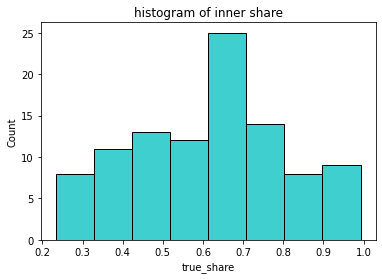

In [343]:
# df_master['true_share'] = true_share_list
# plt.hist(df_master.groupby('t')['true_share'].sum())

sns.histplot(df_master.groupby('t')['true_share'].sum(), color = 'c')
plt.title("histogram of inner share")
plt.show()

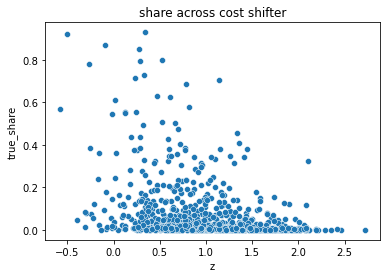

In [309]:
sns.scatterplot(x = df_master['z'], y = df_master['true_share'])
plt.title("share across cost shifter")
plt.show()

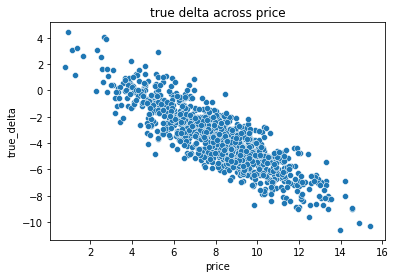

In [313]:
sns.scatterplot(x = df_master['price'], y = df_master['true_delta'])
plt.title("true delta across price")
plt.show()

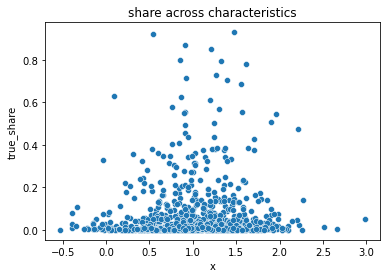

In [282]:
sns.scatterplot(x = df_master['x'], y = df_master['true_share'])
plt.title("share across characteristics")
plt.show()

In [344]:
df_master['constant'] = np.ones(1000)
ideal_result = sm.OLS(df_master['true_delta'], df_master[['constant', 'x', 'price', 'xi']]).fit()
ideal_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             true_delta   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.603e+31
Date:                Tue, 28 Feb 2023   Prob (F-statistic):               0.00
Time:                        14:17:40   Log-Likelihood:                 31477.
No. Observations:                1000   AIC:                        -6.295e+04
Df Residuals:                     996   BIC:                        -6.293e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant       3.0000   6.22e-16   4.82e+15      0.000       3.000       3.000
x              1.5000   3.46e-16   4.33e+15      0.000       1.500       1.500
price         -1.0028   7.32e-17  -1.37e+16      0.000      -1.003      -1.003
xi             1.0000   1.71e-16   5.84e+15      0.000       1.000       1.000
==============================================================================
Omnibus:                       24.127   Durbin-Watson:                   0.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.291
Skew:                           0.386   Prob(JB):                     3.22e-06
Kurtosis:                       3.098   Cond. No.                         33.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Part B. GMM estimation

In [316]:
df_observable = df_master

In [317]:
# construct IV
df_avrg_x = df(df_observable.groupby('t')['x'].mean())
df_avrg_z = df(df_observable.groupby('t')['z'].mean())
df_avrg_x = df_avrg_x.rename(columns= {"x": "avrg_x"})
df_avrg_z = df_avrg_z.rename(columns= {"z": "avrg_z"})
df_avrg_x = df_avrg_x.reset_index()
df_avrg_z = df_avrg_z.reset_index()

df_observable = pd.merge(df_observable, df_avrg_x, left_on= "t", right_on= "t")
df_observable = pd.merge(df_observable, df_avrg_z, left_on= "t", right_on= "t")

df_observable['IV2'] = (10*df_observable['avrg_x'] - df_observable['x'])/9
df_observable['IV3'] = (10*df_observable['avrg_z'] - df_observable['z'])/9

In [434]:
def obj_function(sigma_beta, df_observable):
    epsilon = 1e-10

    # step 1: compute the fixed point
    delta_list = []
    for t in range(1, 101):
        work_data = df_observable.loc[df_observable['t'] == 100]

        # 1. set the initial vector of theta (name it delta_pre)
        share_outer = 1 - work_data['true_share'].sum()
        #delta_pre = np.log(work_data['true_share'].values / share_outer) 
        delta_pre = np.log(work_data['true_share'].values) 


        # 2. update delta by searching for the fixed point
        #    calculate model predicted share with MC integration    
        # fix the seed for random nu
        np.random.seed(3)
        nu_draw = np.random.normal(0, 1, 2000)
        while True:    
            # 2-1. calculate denominator
            #nu_draw = np.random.normal(0, 1, 2000)
            exp_common = 0
            for j in range(10):
                delta_j = delta_pre[j]
                p_j = work_data['price'].values[j]
                exp_j = np.exp(delta_j + sigma_beta*p_j*nu_draw)     ##### sigma beta matters here #####
                exp_common += exp_j
            denominator_common = 1+ exp_common
                
            # 2-2. calculate market share for 10 products 
            share_list_temp = []
            for j in range(10):
                delta_j = delta_pre[j]
                p_j = work_data['price'].values[j]
                exp_j = np.exp(delta_j + sigma_beta*p_j*nu_draw)
                s_j = (exp_j/denominator_common).mean()
                share_list_temp.append(s_j)

            # 2-3. update delta
            share_list_array = np.array(share_list_temp)
            delta_post = delta_pre + np.log(work_data['true_share'].values / share_list_array) 

            # 3. Break Condition and Update
            if abs(delta_post - delta_pre).max() < epsilon:
                break
            else: 
                delta_pre = delta_post
        
        delta_list_temp = list(delta_pre)
        delta_list = delta_list + delta_list_temp

    df_observable['delta_FXP'] = delta_list
    df_observable['delta_error'] = abs(df_observable['true_delta'].values - df_observable['delta_FXP'].values)
    good_sample = df_observable.loc[df_observable['delta_error'] <= 0.5]
    
    #step 2: 2SLS
    IV_result = IV2SLS(dependent=good_sample['delta_FXP'],
                    exog = good_sample[['constant', 'x']],
                    endog = good_sample['price'],
                    instruments=good_sample[['z', 'IV2', 'IV3']]).fit()

    alpha_0_hat = IV_result.params[0]
    alpha_1_hat = IV_result.params[1]
    beta_bar_hat = IV_result.params[2]
    
    IV_result.params
    xi_array = (good_sample['delta_FXP'] - alpha_0_hat*good_sample['constant'] - alpha_1_hat*good_sample['x'] - beta_bar_hat*good_sample['price']).values

    g1_bar = (xi_array * good_sample['z'].values).mean()
    g2_bar = (xi_array * good_sample['IV2'].values).mean()
    g3_bar = (xi_array * good_sample['IV3'].values).mean()

    return g1_bar**2 + g2_bar**2 + g3_bar**2


In [458]:
GMM_result = minimize(obj_function, 0.3, args = (df_observable), bounds = ((0,2),), method='Nelder-Mead', options={'maxiter':200, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.000126
         Iterations: 11
         Function evaluations: 23


In [460]:
sigma_beta = GMM_result.x[0]
epsilon = 1e-10

delta_list = []
for t in range(1, 101):
    work_data = df_observable.loc[df_observable['t'] == 100]

    # 1. set the initial vector of theta (name it delta_pre)
    share_outer = 1 - work_data['true_share'].sum()
    #delta_pre = np.log(work_data['true_share'].values / share_outer) 
    delta_pre = np.log(work_data['true_share'].values) 


    # 2. update delta by searching for the fixed point
    #    calculate model predicted share with MC integration    
    # fix the seed for random nu
    np.random.seed(3)
    nu_draw = np.random.normal(0, 1, 2000)
    while True:    
        # 2-1. calculate denominator
        #nu_draw = np.random.normal(0, 1, 2000)
        exp_common = 0
        for j in range(10):
            delta_j = delta_pre[j]
            p_j = work_data['price'].values[j]
            exp_j = np.exp(delta_j + sigma_beta*p_j*nu_draw)     ##### sigma beta matters here #####
            exp_common += exp_j
        denominator_common = 1+ exp_common
            
        # 2-2. calculate market share for 10 products 
        share_list_temp = []
        for j in range(10):
            delta_j = delta_pre[j]
            p_j = work_data['price'].values[j]
            exp_j = np.exp(delta_j + sigma_beta*p_j*nu_draw)
            s_j = (exp_j/denominator_common).mean()
            share_list_temp.append(s_j)

        # 2-3. update delta
        share_list_array = np.array(share_list_temp)
        delta_post = delta_pre + np.log(work_data['true_share'].values / share_list_array) 

        # 3. Break Condition and Update
        if abs(delta_post - delta_pre).max() < epsilon:
            break
        else: 
            delta_pre = delta_post
    
    
    delta_list_temp = list(delta_pre)
    delta_list = delta_list + delta_list_temp

df_observable['delta_FXP'] = delta_list
df_observable['delta_error'] = abs(df_observable['true_delta'].values - df_observable['delta_FXP'].values)
good_sample = df_observable.loc[df_observable['delta_error'] <= 0.5]

#step 2: 2SLS
IV_result = IV2SLS(dependent=good_sample['delta_FXP'],
                exog = good_sample[['constant', 'x']],
                endog = good_sample['price'],
                instruments=good_sample[['z', 'IV2', 'IV3']]).fit()

alpha_0_hat = IV_result.params[0]
alpha_1_hat = IV_result.params[1]
beta_bar_hat = IV_result.params[2]


print("alpha_0_hat: ", alpha_0_hat)
print("alpha_1_hat: ", alpha_1_hat)
print("beta_bar_hat: ", beta_bar_hat)
print("sigma_beta_hat: ", sigma_beta)

alpha_0_hat:  2.4903099207696346
alpha_1_hat:  1.4600014144712876
beta_bar_hat:  -0.9351165549604872
sigma_beta_hat:  0.29859375


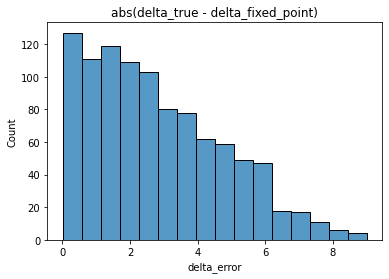

In [464]:
sns.histplot(df_observable['delta_error'])
plt.title("abs(delta_true - delta_fixed_point)")
plt.show()